Problem 12: As discussed in class (9/15 - 17), the leaky integrate-and-fire (LIF) model provides a useful starting point to understand how neurons communicate and compute with spike trains. Drawing upon the methods described in [Neural Engineering Chapter 4](https://redwood.berkeley.edu/wp-content/uploads/2020/08/Ch4-Eliasmith-Anderson.pdf), show how a time-varying signal can be nonlinearly encoded into spikes and linearly decoded by downstream post-synaptic processes (i.e., replicate Figure 4.9). For the LIF model you may wish to build upon the membrane equation from Problem 5 with a current source as input, but now adding on a threshold and spike generating and reset mechanism. The basic methods for deriving a decoding filter and signal reconstruction are described in eqs. 4.19, 4.23, but you may wish to consider other methods as well. Evaluate the quality of reconstruction in terms of SNR as a function of various parameters of the model, such as membrane time constant, refractory period, and the overall bandwidth of the input signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from math import sqrt
import random as rand
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("hls", 8)
sns.set()

# 1. Modeling the Leaky Integrate-and-Fire Neuron

The LIF neuron can be thought of as a passive RC circuit coupled to an active spike generator. It has two behavioral regimes: sub-threshold and super-threshold. In the sub-threshold regime, the LIF neuron behaves the same as a passive RC circuit. However, once the threshold is reached, the LIF neuron exhibits super-threshold behavior and fire a delta-function voltage spike. After firing, the neuron is then reset to the resting potential for some time period, ${\tau}_{ref}$, before it returns to its sub-threshold behavior.

![The Leaky Integrate-and-Fire Neuron](img/The Leaky Integrate-and-Fire Neuron.png)

## 1.1 Modeling the passive neuron
In the sub-threshold regime, the LIF neuron behaves the same as a passive RC circuit and can be described by the membrane equation: 
$$ \tau \frac{dV}{dt} = -(V - V_{rest}) + \frac{I_{inj}(t)}{G_{leak}}$$
where we define $\tau$ as: 
$$\tau = \frac{C}{G_leak}$$
To model the passive RC circuit, we adopt the following values for the membrane equation parametrs:
- Initial condition: $V(0) = V_{rest} = -70 mV$
- Membrane capacitance: $C = 100 pF$
- $G_{Leak} = 5 nS$.

In [2]:
# initiate the membrane equation parameters
V_0 = -70            
C = 100                 
G_LEAK = 5   
TAU_RC = C/G_LEAK

We use Euler's rule to update the voltage according to the membrane equation (1). Then for a given step input current, we can plot the membrame voltage as a function of time:

In [3]:
# define the membrane equation update rule
def membrane_equation_ODE(V, I_ti, V_0=V_0, tau_RC=TAU_RC, G_leak=G_LEAK, dt=0.1):
    dV = (-(V - V_0) + I_ti/G_leak)/tau_RC*dt
    V = V+dV
    return V

In [4]:
# define an injected current
def I_step(t):               
    if t < 510 and t > 100: 
        return 100
    else:
        return 0

In [5]:
# find I(t) and V(t) for a given time interval 
t = np.linspace(0, 800, 8000)
dt = 0.1
I_t_step = [I_step(i) for i in t]
V_t = np.zeros(len(t))
V_t[0] = V_0
for i in range(len(t)-1):
    V_t[i+1] = membrane_equation_ODE(V_t[i], I_t_step[i])

Text(0.5,0,'time (ms)')

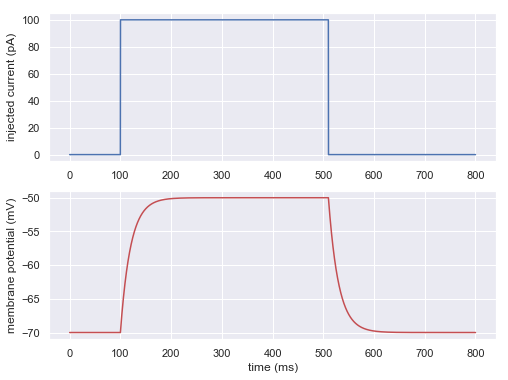

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(t, I_t_step, 'b')
ax1.set_ylabel('injected current (pA)')
ax2.plot(t, V_t, 'r')
ax2.set_ylabel('membrane potential (mV)')
ax2.set_xlabel('time (ms)')

## 1.2 Modeling the LIF neuron
In the super-threshold regime,the LIF neuron is described by the additional threshold and reset mechanism, indicated by the components inside the dashed box in the figure below.
![LIF RC circuit](img/LIF RC circuit.png)
We define two additional parameters:
- Threshold: $V_{thresh} = -60 mV$
- Refractionary period: $\tau_{ref} = 5 ms $ 

In [7]:
V_thresh = -55
TAU_REF = 3 

def LIF_neuron(I_t, t, V_0=V_0, tau_RC=TAU_RC, tau_ref=TAU_REF, G_leak=G_LEAK, dt=0.1):
    V_t = np.zeros(len(t))
    V_t[0] = -70
    t_spikes = []
    for i in range(len(t)-1):   
        # if a spike just occurred within refractory period, then the neuron is still resting 
        if  any(t_spike>t[i] - tau_ref for t_spike in t_spikes):
            V_t[i+1] = V_0
        # else, if the voltage just arrived at the threshold, spike!
        elif V_t[i]>=V_thresh:
            V_t[i+1] = V_thresh + 10
            t_spikes.append(t[i+1])
        # else, just keep integrating the voltage, same as a passive neuron
        else:
            V_t[i+1] = membrane_equation_ODE(V=V_t[i], I_ti=I_t[i], V_0=V_0, tau_RC=TAU_RC)
    return V_t, t_spikes

Text(0.5,0,'time (ms)')

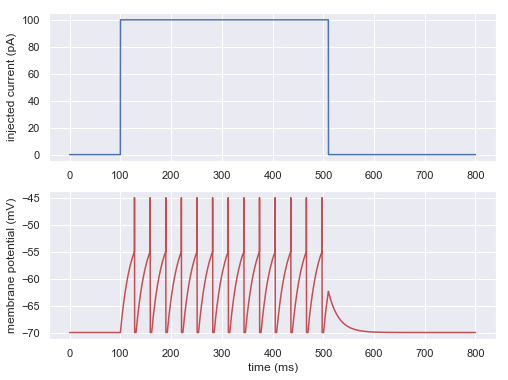

In [8]:
V_t, t_spikes = LIF_neuron(I_t_step, t, V_0=V_0, G_leak=G_LEAK, tau_RC=TAU_RC, dt=0.1)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(t, I_t_step, 'b')
ax1.set_ylabel('injected current (pA)')
ax2.plot(t, V_t, 'r')
ax2.set_ylabel('membrane potential (mV)')
ax2.set_xlabel('time (ms)')

Great! Now we are seeing the expected behavior for LIF neurons. Notice that the membrane potential gradually returns to resting potential after the input current ceases.

# 2. Encoding and decoding

## 2.1 Encoding an emsemble of signals with LIF
Despite that many experiments in neurophysiology use very unnatural signals like step functions to evoke neural resonponse, most signals you encounter in nature are not step functions. In particular, using signals  from a more natural ensemble often shows neurons to be more adept at passing information.

In particualr, we will follow Neural Engineering Chap 4. and try to find a linear decoder that is good for an ensemble of signals. The reason is that naturally occurring signals are usually statinary, i.e. the statistics of any sample of the signals are time-independent. In particular, we can write an ensemble as a Fourier series
$$ x(t; A) = \sum_{n=-(N-1)/2}^{(N-1)/2} A(\omega_n)e^{i \omega_n t}$$

We will now look an ensamble of signals and check out how LIF neurons respond to it. We consider a simple encoding system with opponency arrangement--two complimentary neurons, whose response profiles mirror one another. Specifically, we center a signal and assume that an 'on' neuron only codes the positive half of the input signal, while an 'off' neuron only codes the negative half of the signal.

In [9]:
def generate_stationary_signal(t, freq=0.01, N=21):
    I_t = np.zeros(len(t))
    for n in range(N): 
         I_t += 5*np.random.normal(10,1)*np.sin(freq*n*t + np.random.normal(0, np.pi))
    ## scale the signal to -300 - 300 pA
    #I_t_max = np.max(I_t)
    #I_t_min = np.min(I_t)
    #I_t = I_t*(300 - (-300))/(I_t_max - I_t_min)
    #I_t = I_t - np.max(I_t) + 300
    return I_t

(0, 805)

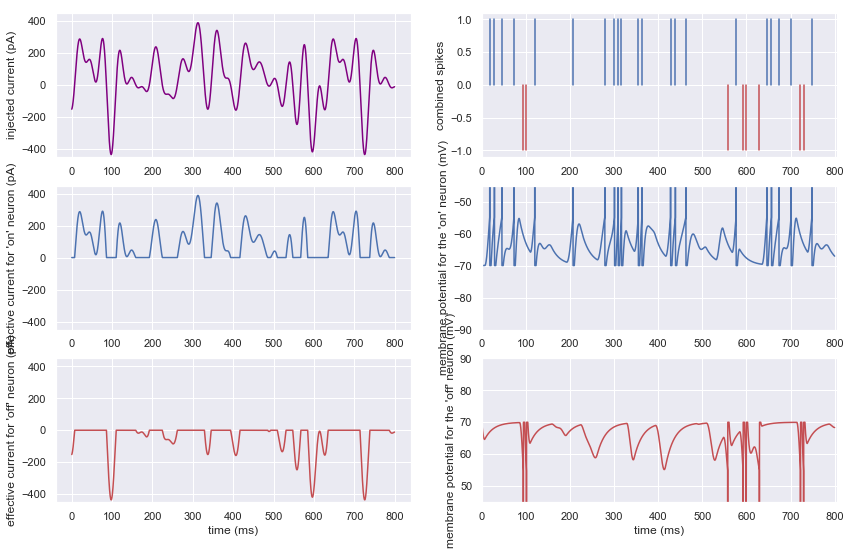

In [10]:
t = np.linspace(0, 800, 8000)
I_t = generate_stationary_signal(t, freq=0.01)
I_t_on = [i if i>0 else 0 for i in I_t]
I_t_off = [i if i<0 else 0 for i in I_t]
V_t_on, t_spikes_on = LIF_neuron(I_t_on, t, V_0=V_0, tau_RC=TAU_RC, tau_ref=TAU_REF, dt=0.1)
V_t_off, t_spikes_off = LIF_neuron(-np.array(I_t_off), t, V_0=V_0, tau_RC=TAU_RC, tau_ref=TAU_REF, dt=0.1)
fig, axes = plt.subplots(3,2,figsize=(14,9))
axes[0, 0].plot(t, I_t, 'purple')
axes[0, 0].set_ylabel('injected current (pA)')
axes[0, 0].set_ylim([-450,450])
axes[1, 0].plot(t, I_t_on, 'b')
axes[1, 0].set_ylabel("effective current for 'on' neuron (pA)")
axes[1, 0].set_ylim([-450,450])
axes[2, 0].plot(t, I_t_off, 'r')
axes[2, 0].set_ylabel("effective current for 'off' neuron (pA)")
axes[2, 0].set_ylim([-450,450])
axes[2, 0].set_xlabel('time (ms)')
axes[1, 1].plot(t, V_t_on, 'b')
axes[1, 1].set_ylabel("membrane potential for the 'on' neuron (mV)")
axes[1, 1].set_xlim([0, 805])
axes[1, 1].set_ylim([-90, -45])
axes[2, 1].plot(t, -np.array(V_t_off), 'r')
axes[2, 1].set_ylabel("membrane potential for the 'off' neuron (mV)")
axes[2, 1].set_xlim([0, 805])
axes[2, 1].set_xlabel('time (ms)')
axes[2, 1].set_ylim([45, 90])
axes[0, 1].plot([t_spikes_on, t_spikes_on], [0, 1], 'b')
axes[0, 1].plot([t_spikes_off, t_spikes_off], [0, -1], 'r')
axes[0, 1].set_ylabel('combined spikes')
axes[0, 1].set_xlim([0, 805])

## 2.2 Decoding
Looking at the figures above, we would think it's possible to recover some information about the injected current from the spike trains: when the current stays in the negative for a while, the 'off' neuron spikes a lot. On the other hand, after the current spends some time in the positive domain, the 'on' neuron picks up. 

How do we extract information about the injected current from the spike trains? One common method is to assume there is some linear system that can decode the spike train, $\delta(t − t_n)$, and reconstructs the original signal.
$$\hat{x}(t) = \sum_{i,k} \Theta_i \delta(t-t_{i,k}) h(t))$$
where $\Theta_i = 1$ for the ‘on’ spikes and −1 for the ‘off’ spikes.

Though more intuitive, it's less efficient to find the linear system in the time domain than in the frequency domain. This is because the number of degrees of freedom in estimating our linear filter is much smaller in the frequency domain.

And as is shown in Neural Engineering Appendix B, we can find an optimal linear decoder solution in the frequency domain for the aforementioned ensemble of signals as:

$$h(\omega_n) = \frac{<A(\omega_n)R^*(\omega_n
; \mathbf{A})>_A}{<|R(\omega_n; \mathbf{A})|^2>_A}$$

where the averaging, $<·>_A$ emphasizes that the terms approximate the average over the stochastic variables, $A$. 

Since we want to transform the spike trains to the frequency domain, we first have to rewrite the spike trains as a function of time.

In [11]:
def get_spikes(t, t_spikes_on, t_spikes_off, dt=0.1):
    # rewrite the spike trains as a function of time
    spikes = np.zeros(len(t))
    spikes[np.floor(np.array(t_spikes_on)/dt).astype(int)] = 1
    spikes[np.floor(np.array(t_spikes_off)/dt).astype(int)] = -1
    return spikes

For simplicity's sake, here we will just average over n box windows of segments sampled from the same signal ensemble. The length of each segment only needs to be a few times longer than $\tau_{RC}$, since the effects of past voltage states fall off exponentially with time and become lost in the noise after a few time constants anyway. For our LIF neuron, $\tau_{RC} = 20 ms$. We choose the segment length as 800 ms, which is certainly long enough.

In [12]:
def encoding(t=t, n_window=100, freq=0.01, tau_RC=TAU_RC, tau_ref=TAU_REF):
    signals = np.zeros((n_window, len(t)))
    spikes = np.zeros((n_window, len(t)))
    for i in range(n_window):
        I_t = generate_stationary_signal(t=t, freq=freq)
        I_t_on = [i if i>0 else 0 for i in I_t]
        I_t_off = [i if i<0 else 0 for i in I_t]
        V_t_on, t_spikes_on = LIF_neuron(I_t_on, t, V_0=V_0, tau_RC=tau_RC, tau_ref=tau_ref, dt=0.1)
        V_t_off, t_spikes_off = LIF_neuron(-np.array(I_t_off), t, V_0=V_0, tau_RC=tau_RC, tau_ref=tau_ref, dt=0.1)
        signals[i] = I_t
        spikes[i] = get_spikes(t, t_spikes_on, t_spikes_off, dt=0.1)
    return signals, spikes    

We write a function for finding the optimal linear decoder solution in the frequence domain $h(\omega_n)$ and then transforming it back to the time domain:

In [13]:
from numpy.fft import fft, ifft
def solve_linear_decoder(signals, spikes):
    n_window, length = signals.shape
    numerator = np.zeros(length, dtype=complex)
    denominator = np.zeros(length)    
    for i in range(n_window):
        # transform to the frequency domain
        spike_freq = fft(spikes[i])
        signal_freq = fft(signals[i])
        numerator += signal_freq*np.conj(spike_freq)
        denominator += np.abs(spike_freq)**2
    #  solve for the linear decoder in the frequency domain
    h_freq = numerator/denominator
    #  transform to the time domain
    h_t = ifft(h_freq)
    return h_freq, h_t

def decoding(h_freq, spikes):
    n_window, length = spikes.shape
    signals_decoded = np.zeros((n_window, length))
    for i in range(n_window):
        spike_freq = fft(spikes[i])
        signals_decoded[i] = ifft(h_freq*spike_freq)
    return signals_decoded

In [14]:
t = np.arange(0, 800, dt) # window length 800 ms
signals, spikes = encoding(t=t, n_window=20, freq=0.01, tau_RC=TAU_RC, tau_ref=TAU_REF)
h_freq, h_t = solve_linear_decoder(signals, spikes)
#signals_decoded = decoding(h_freq, spikes)

We write a plot function for comparing the original and the reconstructed signal: 

In [15]:
def plot_decoded_signal(t, signal, signal_decoded):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(t, signal, 'b', label='original signal')
    ax.plot(t, signal_decoded, '--r', label='reconstructed signal')
    ax.legend(loc="best")
    ax.set_ylabel('current (pA)')
    ax.set_xlabel('time (ms)')

Now we generate 10 new signals from the same ensemble - signals that the linear decoder has never seen before, and take a look of the reconstructed signals vs the orignal signals. Here we plot the first five reconstructed and orignal signal pairs: 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


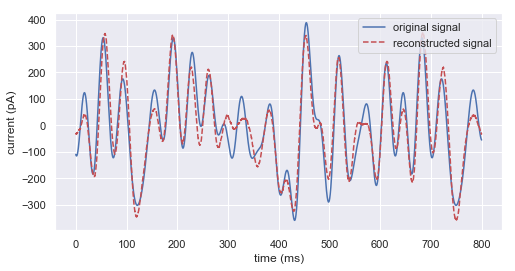

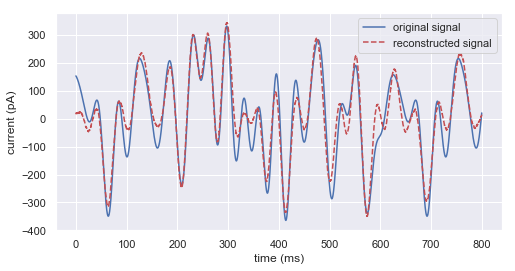

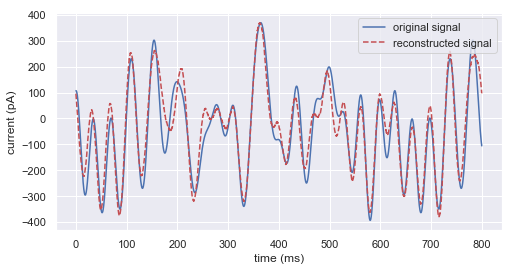

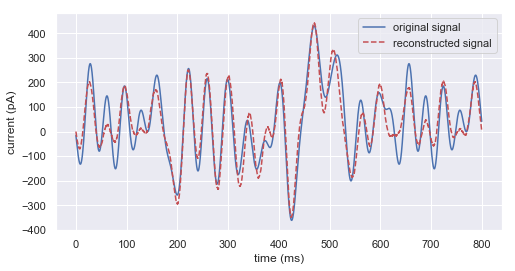

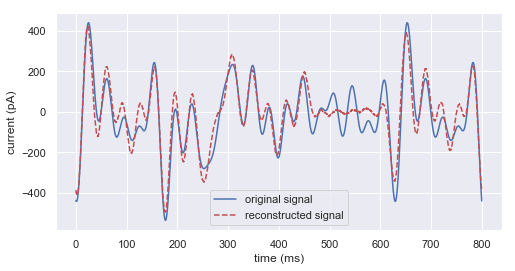

In [16]:
np.arange(0, 800, dt) # window length 800 ms
signals_test, spikes_test = encoding(t=t, n_window=10, freq=0.01, tau_RC=TAU_RC, tau_ref=TAU_REF)
signals_test_decoded = decoding(h_freq, spikes_test)
for i in range(5):
    plot_decoded_signal(t, signals_test[i], signals_test_decoded[i])

Not bad at all!!! Now we need a quantitative way to evaluate our reconstruction based on LIF neuron spike trains.

## 2.3 Measuring the efficiency of information transmission
In order to determine the information that is transmitted under the linear decoder, we calculate the SNR, signal-to-noise ratio of the channel. 
$$SNR = \frac{<{\hat{x}}^{2}>_x}{<MSE>_x} = \frac{<{\hat{x}}^2>_x}{<[x - \hat(x)]^2>_x}$$
where $\hat{x}$ is the linear estimate of the original signal given the LIF neuron responses.

In [17]:
def SNR(signals, signals_decoded):
    numerator = np.sum(signals_decoded**2)
    denominator = np.sum((signals - signals_decoded)**2)
    return numerator/denominator

Now we can calculate the SNR for the 10 test signals that we generated:

In [18]:
SNR(signals_test, signals_test_decoded)

7.934715904152641

A natural question that arises is how the SNR changes with parameters of the encoding model, such as membrane time constant, refractory period, and the overall bandwidth of the input signal.

In [19]:
def compare_SNR(t=np.arange(0, 800, dt), freq=0.01, tau_RC=TAU_RC, tau_ref=TAU_REF):
    print(f'Parameters: freq = {freq}, tau_RC = {tau_RC}, tau_ref = {tau_ref}')
    signals, spikes = encoding(t, n_window=20, freq=freq, tau_RC=tau_RC, tau_ref=tau_ref)
    h_freq, h_t = solve_linear_decoder(signals, spikes)
    signals_decoded = decoding(h_freq, spikes)
    result = SNR(signals, signals_decoded)
    print(f'SNR = {result}')
    return result

Let's take a look at SNR for lists of $\tau_RC$, $\tau_ref$ and bandwidth:

In [21]:
t = np.arange(0, 800, dt)
tau_RC_list = [5, 10, 20, 40, 80]
tau_ref_list = [0.5, 1, 2, 4, 8]
freq_list = [0.0002, 0.001, 0.005, 0.025, 0.125]
SNR_grid = np.zeros(((len(freq_list), len(tau_RC_list), len(tau_ref_list))))
for i in range(len(freq_list)):
    for j in range(len(tau_RC_list)):
        for k in range(len(tau_ref_list)):
            SNR_grid[i, j, k]= compare_SNR(freq=freq_list[i], tau_RC=tau_RC_list[j], tau_ref=tau_ref_list[k])
#np.save('SNR_grid.npy', SNR_grid)
#SNR_grid = np.load('SNR_grid.npy')

Parameters: freq = 0.0002, tau_RC = 5, tau_ref = 0.5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


SNR = 16.409617251952984
Parameters: freq = 0.0002, tau_RC = 5, tau_ref = 1
SNR = 16.31478361221777
Parameters: freq = 0.0002, tau_RC = 5, tau_ref = 2
SNR = 18.461737557692306
Parameters: freq = 0.0002, tau_RC = 5, tau_ref = 4
SNR = 9.504613329130299
Parameters: freq = 0.0002, tau_RC = 5, tau_ref = 8
SNR = 27.378686325908074
Parameters: freq = 0.0002, tau_RC = 10, tau_ref = 0.5
SNR = 24.703784320021875
Parameters: freq = 0.0002, tau_RC = 10, tau_ref = 1
SNR = 35.79373317448321
Parameters: freq = 0.0002, tau_RC = 10, tau_ref = 2
SNR = 54.79798752621928
Parameters: freq = 0.0002, tau_RC = 10, tau_ref = 4
SNR = 31.79304595656339
Parameters: freq = 0.0002, tau_RC = 10, tau_ref = 8
SNR = 21.853109079045144
Parameters: freq = 0.0002, tau_RC = 20, tau_ref = 0.5
SNR = 16.412815509109983
Parameters: freq = 0.0002, tau_RC = 20, tau_ref = 1
SNR = 26.858421243398954
Parameters: freq = 0.0002, tau_RC = 20, tau_ref = 2
SNR = 35.66497551543438
Parameters: freq = 0.0002, tau_RC = 20, tau_ref = 4
SNR =

SNR = 0.252224870600193
Parameters: freq = 0.125, tau_RC = 10, tau_ref = 8
SNR = 0.2381311791216122
Parameters: freq = 0.125, tau_RC = 20, tau_ref = 0.5
SNR = 0.2982408714880046
Parameters: freq = 0.125, tau_RC = 20, tau_ref = 1
SNR = 0.31001197662848046
Parameters: freq = 0.125, tau_RC = 20, tau_ref = 2
SNR = 0.2451976533731883
Parameters: freq = 0.125, tau_RC = 20, tau_ref = 4
SNR = 0.2884546572045079
Parameters: freq = 0.125, tau_RC = 20, tau_ref = 8
SNR = 0.22091479841793024
Parameters: freq = 0.125, tau_RC = 40, tau_ref = 0.5
SNR = 0.29174575352207877
Parameters: freq = 0.125, tau_RC = 40, tau_ref = 1
SNR = 0.33275433577088637
Parameters: freq = 0.125, tau_RC = 40, tau_ref = 2
SNR = 0.33603321016367027
Parameters: freq = 0.125, tau_RC = 40, tau_ref = 4
SNR = 0.2686299254824177
Parameters: freq = 0.125, tau_RC = 40, tau_ref = 8
SNR = 0.19858280734712802
Parameters: freq = 0.125, tau_RC = 80, tau_ref = 0.5
SNR = 0.31454765589499495
Parameters: freq = 0.125, tau_RC = 80, tau_ref = 1


In [2]:
dt = 0.1
t = np.arange(0, 800, dt)
tau_RC_list = [5, 10, 20, 40, 80]
tau_ref_list = [0.5, 1, 2, 4, 8]
freq_list = [0.0002, 0.001, 0.005, 0.025, 0.125]
SNR_grid = np.load('SNR_grid.npy')

In order to interpret the result, we use 3D visualization to show SNR as a function of all the parameters. This visualization is inspired by [this blog post](https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9).

In [12]:
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
py.init_notebook_mode(connected=True)

In [14]:
data = []
for i in range(len(freq_list)):
    traces = go.Surface(z=SNR_grid[i], x=tau_RC_list, y=tau_ref_list,
                   colorscale='Viridis', showscale=False, name=f'R2 scores VS n_estimators and max_features', visible=False)
    data.append(traces)
data[0]['visible'] = True
steps = []
for i, n in enumerate(freq_list):
    step = dict(method = 'restyle', args = ['visible', [False] * len(data) ],)
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['label'] = str(n*2e4) +' Hz'
    steps.append(step)
sliders = [ dict(
    active = 0,
    currentvalue = {"prefix": "Bandwidth: "},
    pad = {"t": 10, 'b': 20},
    steps = steps,
    len=0.6,
    xanchor = 'center',
    x = 0.5 ) ]
layout = go.Layout(title='SNR as a function of LIF parameters',
    margin=dict(l=30, r=30, b=30,t=30),
    sliders=sliders,
    scene = dict(xaxis = dict(title='tau_RC (ms)',), 
                 yaxis = dict(title='tau_ref (ms)',),
                 zaxis = dict(title='SNR',),
        aspectratio = dict(x = 1, y = 1, z = 1),
        camera = dict(eye = dict(y = 2, x = -0.55, z = 0.15,)),),)
fig = go.Figure(data=data, layout=layout)
plot(fig)

'temp-plot.html'

In [15]:
fig.show()

You can drag the slider to visualize the result at different bandwidth. Be aware that the SNR axis are scaled differently at each step! 
The most evident finding from looking at the plot is that generally the smaller bandwidth gives better performance. The dependence of the SNR on $\tau_RC$ and $\tau_ref$ on the other hand is more complex. 
We then plot the best and the worst SNR scenario:

The best reconstruction:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning:

Casting complex values to real discards the imaginary part



The best reconstruction:
bandwidth = 4.0 Hz
tau_RC = 20 ms
tau_ref = 4 ms


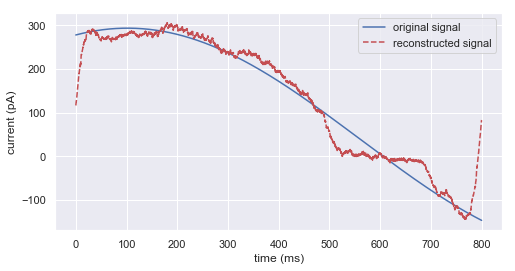

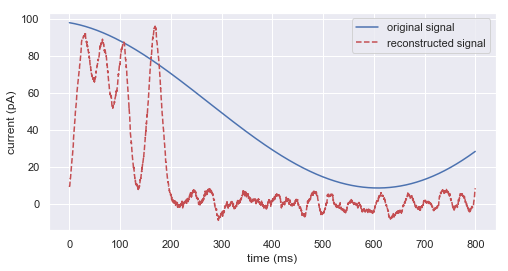

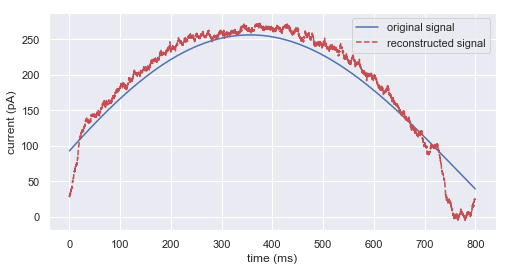

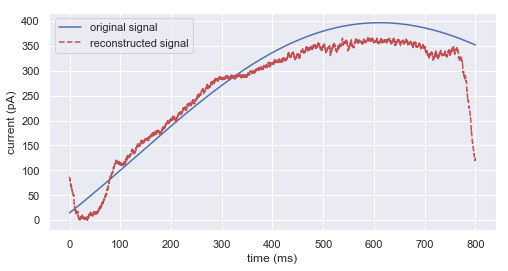

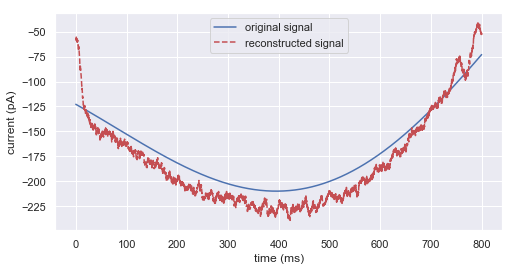

In [24]:
i, j, k = np.where(SNR_grid==np.amax(SNR_grid))
t = np.arange(0, 800, dt) # window length 800 ms
signals, spikes = encoding(t=t, n_window=20, freq=freq_list[i[0]], tau_RC=tau_RC_list[j[0]], tau_ref=tau_ref_list[k[0]])
h_freq, h_t = solve_linear_decoder(signals, spikes)
signals_decoded = decoding(h_freq, spikes)
print(f'The best reconstruction:\nbandwidth = {freq_list[i[0]]*2e4} Hz\ntau_RC = {tau_RC_list[j[0]]} ms\ntau_ref = {tau_ref_list[k[0]]} ms')
for i in range(5):
    plot_decoded_signal(t, signals[i], signals_decoded[i])

At a very low bandwidth, 4 Hz, the signal has very long correlation time. The linear filter still works surprisingly well for signals with long correlation times. The reason for this is that RC circuits function as low pass filters, and thus are better able to preserve lower frequencies.

The worse reconstruction:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning:

Casting complex values to real discards the imaginary part



The worst reconstruction:
bandwidth = 2500.0 Hz
tau_RC = 40 ms
tau_ref = 8 ms


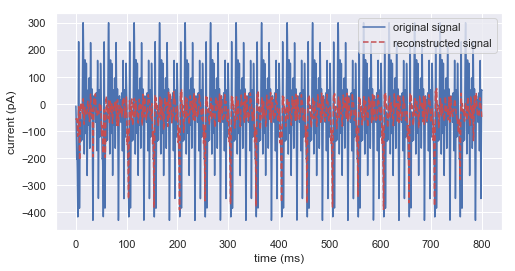

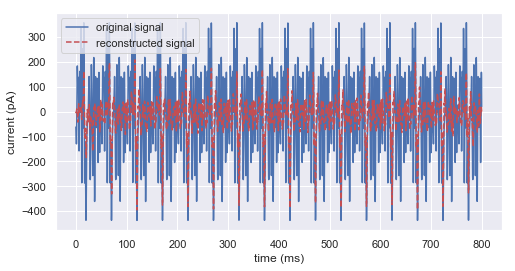

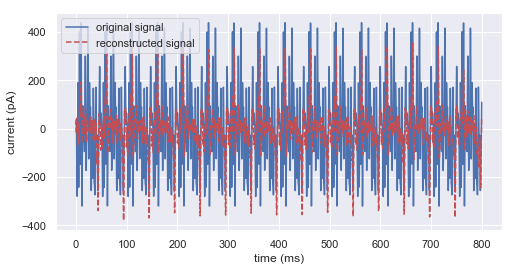

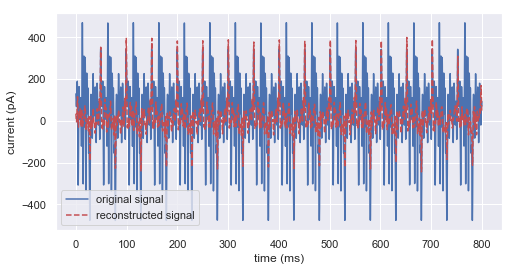

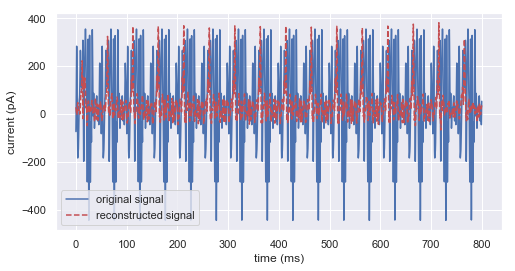

In [25]:
i, j, k = np.where(SNR_grid==np.amin(SNR_grid))
t = np.arange(0, 800, dt) # window length 800 ms
signals, spikes = encoding(t=t, n_window=20, freq=freq_list[i[0]], tau_RC=tau_RC_list[j[0]], tau_ref=tau_ref_list[k[0]])
h_freq, h_t = solve_linear_decoder(signals, spikes)
signals_decoded = decoding(h_freq, spikes)
print(f'The worst reconstruction:\nbandwidth = {freq_list[i[0]]*2e4} Hz\ntau_RC = {tau_RC_list[j[0]]} ms\ntau_ref = {tau_ref_list[k[0]]} ms')
for i in range(5):
    plot_decoded_signal(t, signals[i], signals_decoded[i])

As expected, the linear decoder approach shows the worst performance at the largest bandwidth, 2500 Hz. What's worth noting is that at 2500 HZ, the linear decoder works better as $\tau_RC$ gets smaller. This makes sense as the LIF neuron with smaller $\tau_RC$ can better keep up with a high-frquency signal.